## History of primary energy in Europe

In [148]:
# Import packages
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import yaml

from message_ix_models.tools.bilateralize.utils import load_config
from message_ix_models.tools.bilateralize.historical_calibration import setup_datapath, import_iea_gas
from message_ix_models.util import package_data_path

In [136]:
df = pd.read_csv(package_data_path('alps_hhi', 'figures', 'data', 'energy-consumption-by-source-and-country.csv'))

In [137]:
dict_dir = package_data_path("node", "R12.yaml")
with open(dict_dir, "r", encoding = 'utf8') as f:
    dict_regions = yaml.safe_load(f)

europe_list = dict_regions['R12_WEU']['child'] + dict_regions['R12_EEU']['child']
df = df[df['Code'].isin(europe_list)]

In [138]:
fuel_colnames = {'Other renewables (including geothermal and biomass) - TWh': 'Other renewables',
                 'Biofuels consumption - TWh': 'Biofuels',
                 'Solar consumption - TWh': 'Solar',
                 'Wind consumption - TWh': 'Wind',
                 'Hydro consumption - TWh': 'Hydro',
                 'Nuclear consumption - TWh': 'Nuclear',
                 'Gas consumption - TWh': 'Gas',
                 'Coal consumption - TWh': 'Coal',
                 'Oil consumption - TWh': 'Oil'}

df = df.groupby(['Year'])[list(fuel_colnames.keys())].sum().reset_index()
df = df.rename(columns = fuel_colnames)
df = df.set_index('Year')

for c in fuel_colnames.keys():
    df[fuel_colnames[c]] *= 0.0036 # TWh to EJ

In [139]:
color_map = {
    'Other renewables': '#B4E197',  # Light green
    'Biofuels': '#7CB342',          # Medium green
    'Solar': '#FFD54F',             # Yellow/gold
    'Wind': '#4FC3F7',              # Light blue
    'Hydro': '#0288D1',             # Blue
    'Nuclear': '#9C27B0',           # Purple
    'Gas': '#FF9800',               # Orange
    'Coal': '#424242',              # Dark gray
    'Oil': '#8B4513'                # Saddle brown
}

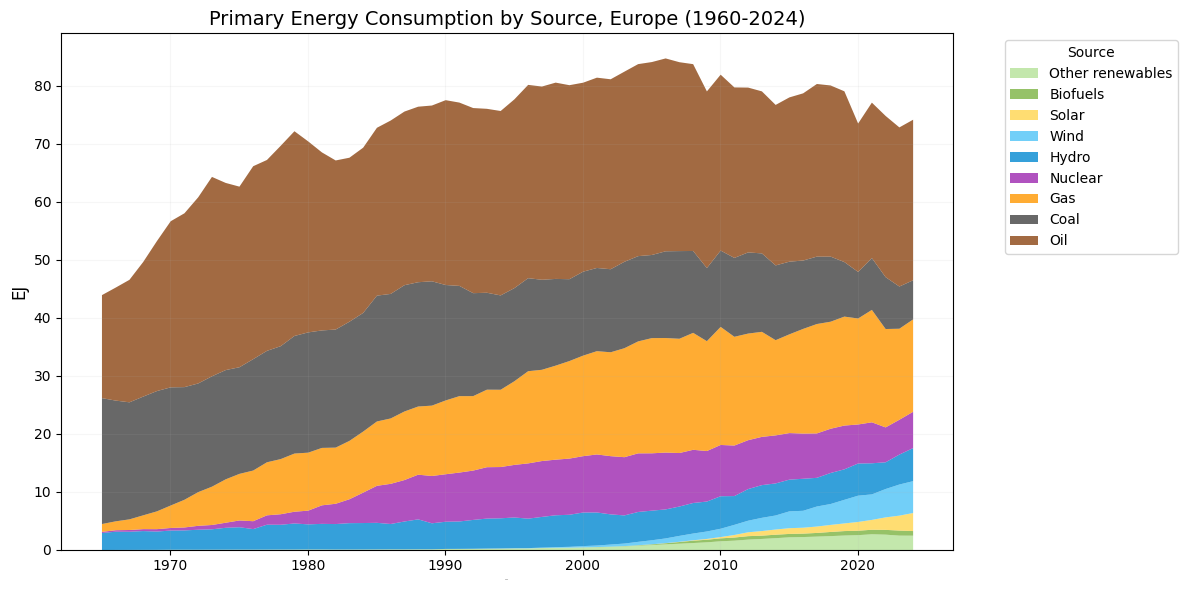

In [146]:
# Create the stacked area chart
fig, ax = plt.subplots(figsize=(12, 6))

# Plot stacked area chart
df.plot.area(ax=ax, alpha=0.8, linewidth=0, color = color_map)

# Customize the chart
ax.set_xlabel('Year', fontsize=0)
ax.set_ylabel('EJ', fontsize=12)
ax.set_title('Primary Energy Consumption by Source, European Countries (1960-2024)', fontsize=14)
ax.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.1)

plt.tight_layout()
plt.show()

In [210]:
# Bring in gas breakdown
ngdf = import_iea_gas(project_name = 'alps_hhi', config_name = 'config.yaml')
ngdf = ngdf[ngdf['IMPORTER'].isin(europe_list)]
ngdf['ENERGY (EJ)'] = ngdf['ENERGY (TJ)']/1e6
ngdf = ngdf[ngdf['ENERGY (EJ)'] > 0]
ngdf = ngdf[ngdf['ENERGY (EJ)'].isnull() == False]
ngdf = ngdf.groupby(['YEAR', 'EXPORTER'])['ENERGY (EJ)'].sum().reset_index()

In [211]:
ngdf_tot = ngdf.groupby(['YEAR'])['ENERGY (EJ)'].sum().reset_index()
ngdf_tot = ngdf_tot.rename(columns = {'ENERGY (EJ)': 'TOTAL ENERGY (EJ)'})
ngdf = ngdf.merge(ngdf_tot,
                  left_on = 'YEAR',
                  right_on = 'YEAR',
                  how = 'left')
ngdf['SHARE'] = ngdf['ENERGY (EJ)']/ngdf['TOTAL ENERGY (EJ)']
ngdf['SHARE'] = np.where(ngdf['SHARE'] > 0.05, ngdf['EXPORTER'], "OTHER")
ngdf = ngdf.groupby(['YEAR', 'SHARE'])['ENERGY (EJ)'].sum().reset_index()

exporter_dict = {'AZE': 'Azerbaijan',
                 'DZA': 'Algeria',
                 'NLD': 'Netherlands',
                 'NOR': 'Norway',
                 'QAT': 'Qatar',
                 'RUS': 'Russia',
                 'USA': 'USA'}
ngdf['EXPORTER'] = 'Other'
for i in exporter_dict.keys():
    ngdf['EXPORTER'] = np.where(ngdf['SHARE'] == i, exporter_dict[i], ngdf['EXPORTER'])

ngdf = ngdf[ngdf['YEAR'] > 2017]

In [212]:
ngdf = ngdf.pivot(index='YEAR', columns='EXPORTER', values='ENERGY (EJ)')

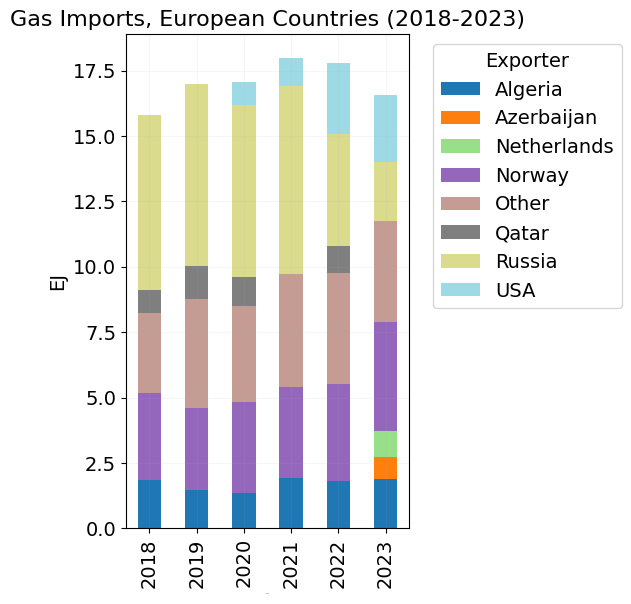

In [229]:
# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(6, 6))

# Plot stacked area chart
ngdf.plot(kind='bar', stacked=True, ax = ax, colormap = 'tab20')

# Customize the chart
ax.set_xlabel('Year', fontsize=0)
ax.set_ylabel('EJ', fontsize=14)
ax.set_title('Gas Imports, European Countries (2018-2023)', fontsize=16)
ax.legend(title='Exporter', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 14, title_fontsize = 14)
ax.grid(True, alpha=0.1)

plt.tight_layout()
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()